## Deadline

Wednesday, November 22, 2017, 11:59PM

## Important notes

- When you push your Notebook to GitHub, all the cells must already have been evaluated.
- Don't forget to add a textual description of your thought process and of any assumptions you've made.
- Please write all your comments in English, and use meaningful variable names in your code.

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 0. Preliminary section

In [1]:
# usual import section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid')

from sklearn import linear_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import networkx as nx

%matplotlib inline

In [2]:
# first let's load the data
data = pd.read_csv('lalonde.csv').set_index('id')
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
# very quick check on the data
print("Shape of the dataFrame: {}".format(data.shape))
print("Number of missing value: {}".format(data.isnull().sum().sum()))
print("Index are unique: {}".format(data.index.is_unique))

Shape of the dataFrame: (614, 10)
Number of missing value: 0
Index are unique: True


As the impact of a job training program is probably going to be different for different revenue before the training we decided to add 4 new features on our dataset:
- `unemployed74` binary feature 1 represent unemployed in 74, 0 otherwise
- `salary74` categorical feature (split the revenu in 3 and categorize low, medium and high income)
- `unemployed75` binary feature 1 represent unemployed in 75, 0 otherwise
- ``salary75`` categorical feature (split the revenu in 3 and categorize low, medium and high income)

We add these features here for convenience even if for our naive analysis we didn't use them.

In [4]:
# add the unemployed features
data['unemployed74'] = (data[['re74']] == 0).astype(int)
data['unemployed75'] = (data[['re75']] == 0).astype(int)

In [5]:
# add the salary features
# set the labels for the different level of salary
# labels = ['very_low', 'low', 'medium', 'high', 'very_high']
int_labels = [1, 2, 3, 4, 5]

out_74, bins = pd.cut(data['re74'], 5, labels=int_labels, retbins=True)

# check out the bins:
print("Bins for the salary in 74:", bins)

out_75 = pd.cut(data['re75'], bins=bins, labels=int_labels)

data['salary74'] = out_74.astype(int)
data['salary75'] = out_75.astype(int)

data.head()

Bins for the salary in 74: [   -35.04007   7008.014    14016.028    21024.042    28032.056    35040.07   ]


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75
id,,,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,1,1,1
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,1,1,1
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,1,1,1
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,1,1,1
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,1,1,1


#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### 1.a numerical approach

First we will use the pandas describe() function to quickly get different stats about the data. We assumed for this question that we were only blindly looking at the outcome re78 for the two groups (treated and untreated).

In [6]:
# we create 2 separate df for treated and untreated people
treated_df = data.query('treat == 1')
untreated_df = data.query('treat == 0')

In [7]:
# use describe on the treated dataframe
treated_df[['re78']].describe()

,re78
count,185.000000
mean,6349.143530
std,7867.402218
min,0.000000
25%,485.229800
50%,4232.309000
75%,9642.999000
max,60307.930000


In [8]:
# use describe on the untreated dataframe
untreated_df[['re78']].describe()

,re78
count,429.000000
mean,6984.169742
std,7294.161791
min,0.000000
25%,220.181300
50%,4975.505000
75%,11688.820000
max,25564.670000


We can now compare the outcome (re78) in terms of stats between the two groups. The first thing ringing bell here is the count value we see that our dataset is not balanced and we have much more untreated subjects than treated (429 against only 185). As we have seen in class unbalanced dataset should be delt with special care.

Regarding the other stats here we know that the min, max, mean, std are not robust statistics and that outliers could change these values a lot however a naive "researcher" could think that since the mean is lower on untreated subjects, the training program didn't have any good impact on the subjects. He could also assume directly from the data that since the std and the maximum is much higher in the treated group that inegality between subjects increased from the treatment. Further more he could also check a robust value such as median to confirm his thinking and see also that the value for untreated is again higher than for the treated subjects.

This would not be considering the fact that some other factors are important here, and all people attending the training program didn't come from same background, didn't have the same age...

#### 1.b graph approach

Here we are looking at 2 groups but one single variable everytime (the outcome re78). So we believe that boxplot and histograms would be the most appropriate graph to plot in this case.

In [33]:
# helper function to plot our histograms
def plt_side_hist(values_list, title_list, bins_list, sharey=False):
    """
        function to plot n*2 histogram side by side
        
        @params:
            - values_list a list of arrays of value to display in each histogram (length (n * 2))
            - title_list a list of title for each histogram (length n)
            - bins_list a list of bins for each histogram (length n)
    """
    # setup title and colors for each cols
    labels = ['untreated', 'treated']
    colors = ['b', 'r']
    
    # setup the fig and number of rows
    nrows = int(len(values_list)/2)
    fig, axes = plt.subplots(nrows=nrows, ncols=2, sharey=sharey)
    fig.set_size_inches(15, 5 * nrows)
    
    # plot each histogram
    for idx, values in enumerate(values_list):
        row = int(idx/2)
        col = idx % 2
        bins = bins_list[row]
        if nrows == 1:
            axes[idx].hist(values, bins, color=colors[col])
            axes[idx].set_title("{} {}".format(labels[col], title_list[row]))
        else:
            axes[row, col].hist(values, bins, color=colors[col])
            axes[row, col].set_title("{} {}".format(labels[col], title_list[row]))

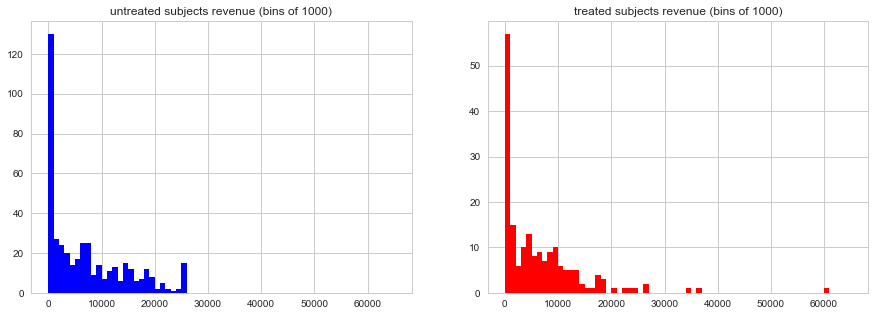

In [10]:
# histogram of the untreated and treated subjects
values_list = [untreated_df['re78'].values, treated_df['re78'].values]
title_list = ["subjects revenue (bins of 1000)"]
bins_list = [range(0, 66000, 1000)]

plt_side_hist(values_list, title_list, bins_list)

We can't observe much here except that in both case we have a big proportion of compensation between 0 and 1000 in both groups. We also observe some bins that seems to appear as outliers in the treated subjects (between 60000 and 61000 of revenue).

To zoom a little bit and observe a little more the data we decided to exclude the 0 value for now.

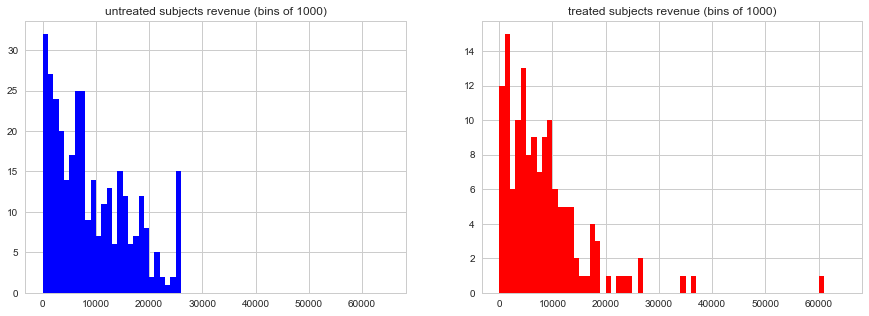

In [11]:
# same thing as above this time keeping only values above 0
values_list = [untreated_df[['re78']].query('re78 > 0').values, 
               treated_df[['re78']].query('re78 > 0').values]
title_list = ["subjects revenue (bins of 1000)"]
bins_list = [range(0, 66000, 1000)]

plt_side_hist(values_list, title_list, bins_list)

We can't really observe an improvement in the shape of the histogram between the 2 groups so again a naive "researcher" could think that this training was useless without looking further. Note that we can clearly identify outliers this time on the treated subject plot. Outliers tends to make the non-robust stats discuss above not representative of the data.

Finally we will add a boxplot to confirm even more our naive findings.

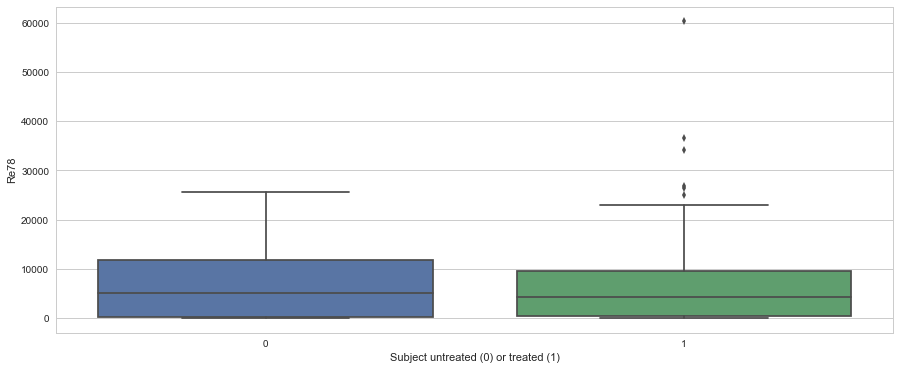

In [12]:
fig = plt.figure(figsize=[15,6])
ax = sns.boxplot( data=[untreated_df['re78'].values, treated_df['re78'].values])
_ = ax.set(xlabel='Subject untreated (0) or treated (1)', ylabel='Re78')

From the boxplot we can again confirm what we said before i.e the untreated subject tends to have a slightly better median we can also clearly observe the outliers again in the treated group data.

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

Here we decided to proceed with the same steps as the previous questions and we started by using the describe function to get an overall description of the stats for each feature individually.

#### 2.a numerical approach

In [13]:
# use describe on the treated dataframe
treated_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.708108,0.600000,1.156757,1.064865
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218,0.455867,0.491227,0.523648,0.323211
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.000000,0.000000,1.000000,1.000000
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,1.000000,1.000000,1.000000,1.000000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,1.000000,1.000000,1.000000,1.000000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,1.000000,1.000000,5.000000,4.000000


In [14]:
# use describe on the untreated dataframe
untreated_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742,0.261072,0.312354,1.522145,1.116550
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791,0.439732,0.463995,0.833077,0.349139
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300,0.000000,0.000000,1.000000,1.000000
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000,0.000000,0.000000,1.000000,1.000000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000,1.000000,1.000000,2.000000,1.000000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000,1.000000,1.000000,4.000000,3.000000


Looking at all the features we see indeed a huge difference between the 2 groups that could definetly explain why we observed such a result in the previous question.

First when observing the previous revenue we observe a huge disparity between the 2 groups indeed the untreated subjects had a much higher mean and median which is probably an important factor to consider when looking at the new revenue. Furthermore, with the unemployed features we just added we can see a very high difference in unemployement before the training in the 2 groups which could also lead to a huge bias in the final result.

Then we can also observe that the treated patient has almost 10% more people without a degree which could also influence the final revenue at the end.

The percentage of married people in the 2 groups is also very different, 19% in the treated group against 51% in the other group.

We have almost a rate of 85% black people in the treated group against arround 20% in the untreated group.
The number of year of education seems to be pretty similar both in mean and median for the 2 groups which is a good news.

And the age is a little different but less pronounced that other criteria.

All these difference between the 2 groups make looking only at the outcome (re78) completly useless as many other factor influence the final revenue such as the different feature listed above (not only the treat features). Comparing 2 groups with marked difference in these features without taking them into account make no-sense hence the naive conclusion from the previous question.

#### 2.b graph approach

Yet again we are talking about comparing each feature distribution one at a time between the 2 groups so barplot and box plot seems to be the more adapted here.

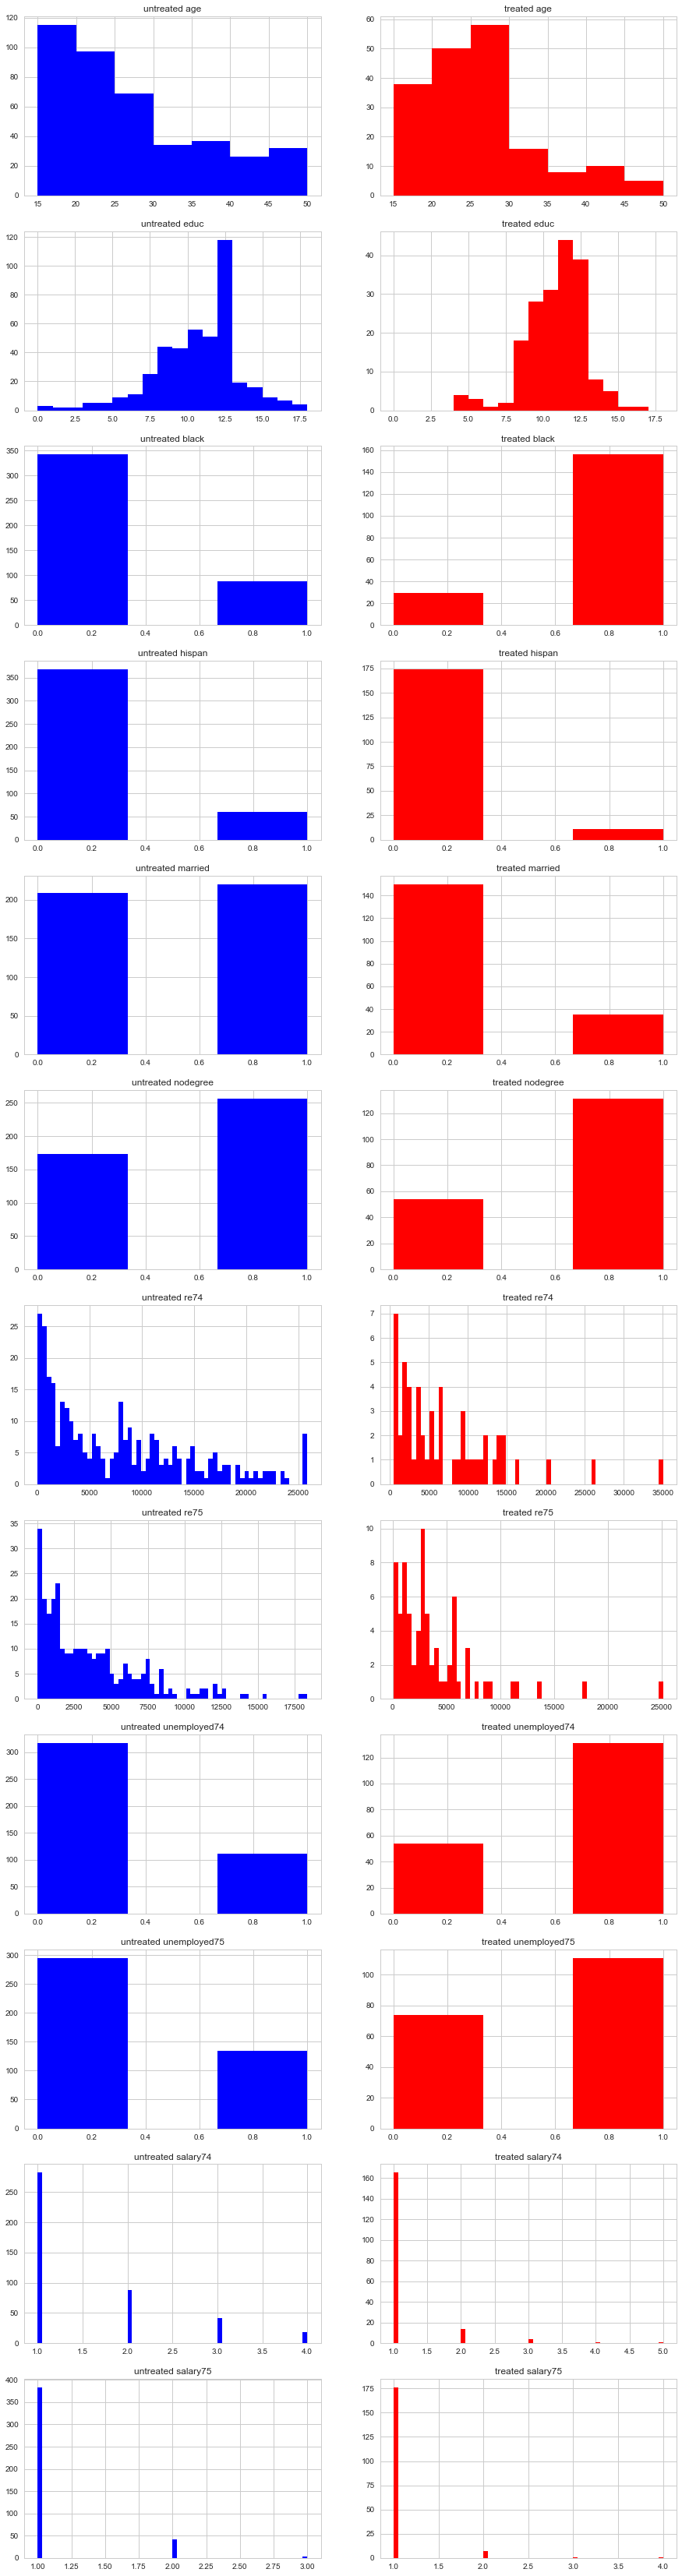

In [15]:
# we can use the same function created earlier this time with each features of the dataframe
values_list = []
title_list = []
bins_list = []
# we select the bins we want for the different data
bins_dic = {
    'age': range(15, 55, 5),
    'educ': range(0, 19, 1),
    'black': 3,
    'hispan': 3,
    'married': 3,
    'nodegree': 3,
    'unemployed74': 3,
    'unemployed75': 3
}

for col in untreated_df.drop(['treat', 're78'], axis=1).columns:
    # we remove the proheminent 0 value in revenue
    if col in ['re74', 're75']:
        values_list.append(untreated_df[[col]].query("{} > 0".format(col)).values)
        values_list.append(treated_df[[col]].query("{} > 0".format(col)).values)
    else:
        values_list.append(untreated_df[col].values)
        values_list.append(treated_df[col].values)
    title_list.append("{}".format(col))
    bins_list.append(bins_dic.get(col, 60)) # we set at 60 bins for each

plt_side_hist(values_list, title_list, bins_list)  

On the different hist we can confirm what we observed from the stats just before. Indeed we see that most of the features have a very different distribution. This difference is particularly present on the different etnics features and the age of the subjects taking the training among the 2 groups as well as the unemployed feature and salary feature we created. We can once more conclude that comparing the 2 groups without considering the disparity between the different features here is not a good choice.

Finally, let's observe this difference on boxplot for each features.

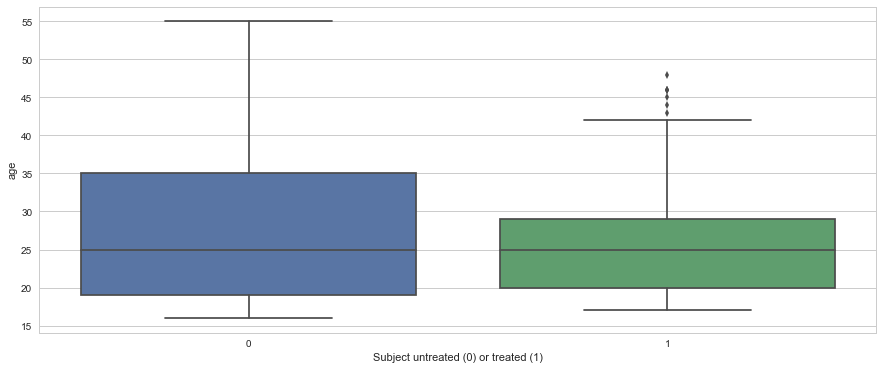

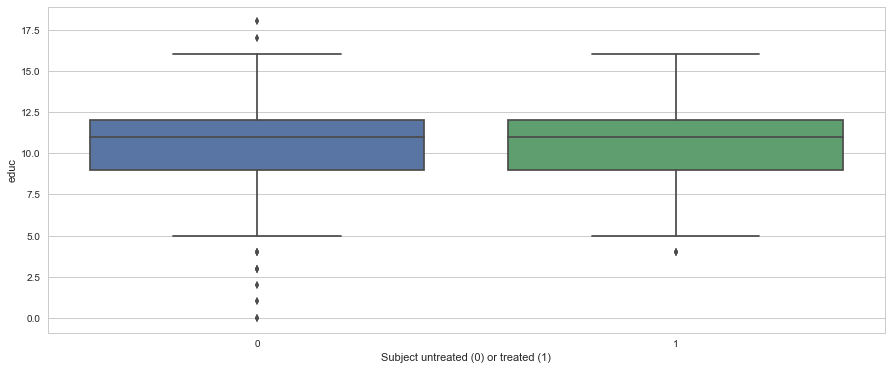

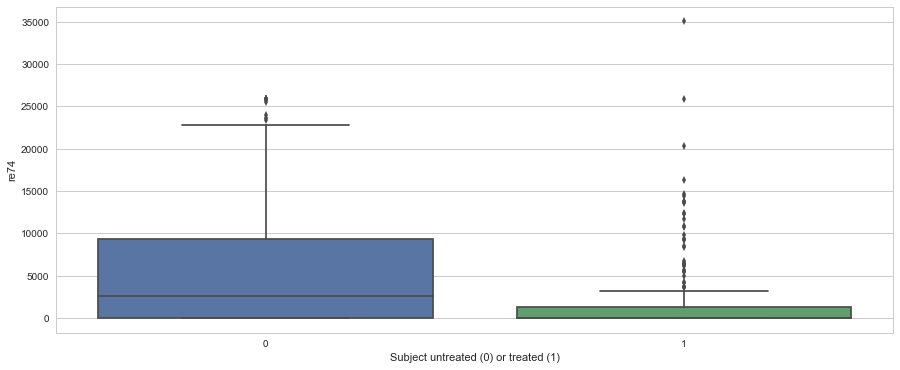

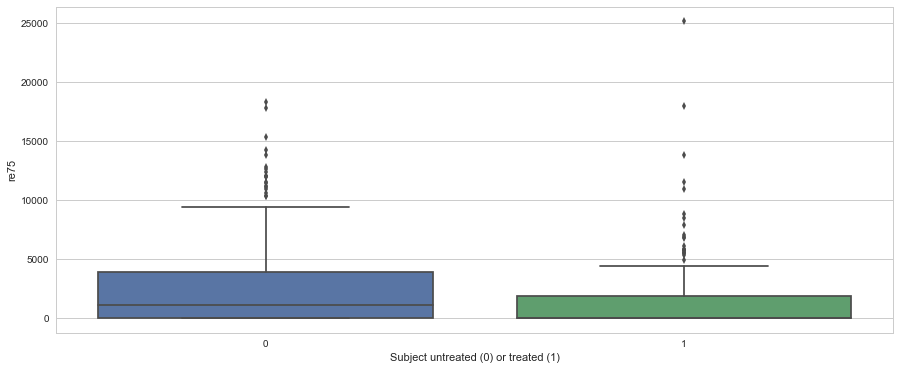

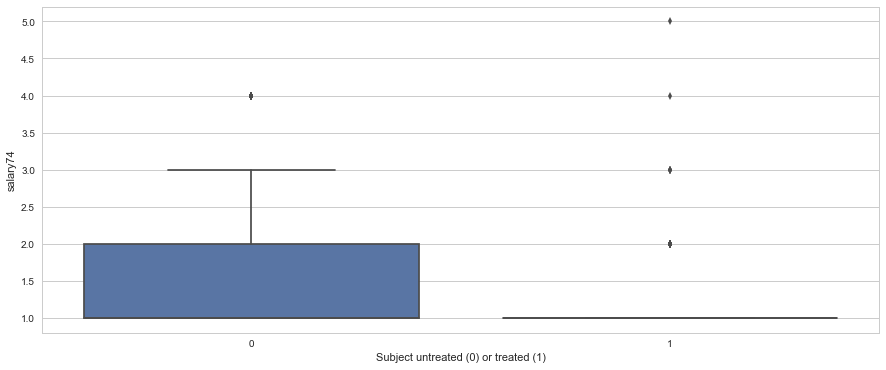

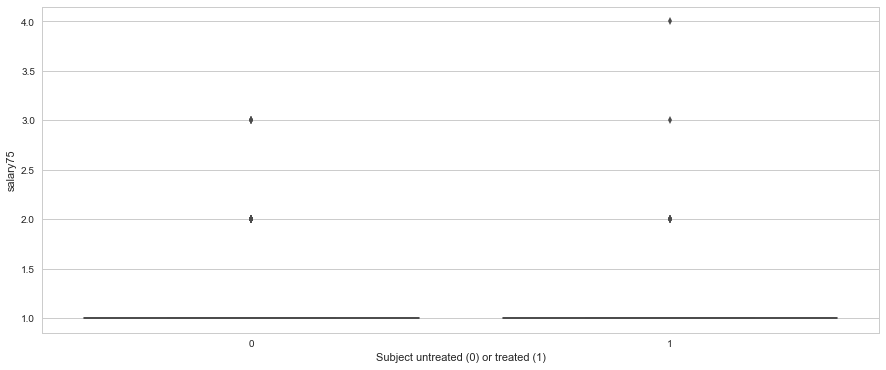

In [16]:
# plot the different boxplot side by side (with binary feature removed)
for col in untreated_df.drop(['treat','black', 'hispan', 'married', 'nodegree', 're78', 'unemployed74', 'unemployed75'], axis=1).columns:
    fig = plt.figure(figsize=[15,6])
    ax = sns.boxplot( data=[untreated_df[col].values, treated_df[col].values])
    ax.set(xlabel='Subject untreated (0) or treated (1)', ylabel=col)

We decided to remove every binary features as a box plot don't represent them well. However we can again observe the difference between the different features of the 2 groups. The difference here is more prononced on the revenue as we can observe a pretty similar median between the ages and education years in the 2 groups. Even though the distribution is always very diverse. 

We observe even more outliers in the revenue boxplot from these features than for the re78 outcome explored during question 1. It means that we should be even more carefull when fitting the model to not overfit those outliers.

To conclude this question we assumed that it's normal that we couldn't find good result in question 1 given the disparity among the 2 groups we are comparing. Especially in terms of previous revenue, previous employement, etnicity.. 

#### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [26]:
# define our model
logistic = linear_model.LogisticRegression(random_state=5)

# define our values
# Note that we know we are using the logistic regression with several features representing the same idea 
# for example (unemployed, salary and revenue) but after iterating a few times we had better result with this setup.
X = data.drop(['treat', 're78'], axis= 1).values
y = data['treat'].values

# fit our model
logistic.fit(X, y)

# estimate the probability of belonging to class [0, 1]
proba = logistic.predict_proba(X)

# check quickly the recall and precision
print("Precision: %0.2f" % (precision_score(y, logistic.predict(X))))
print("Recall: %0.2f" % (recall_score(y, logistic.predict(X))))

Precision: 0.72
Recall: 0.72


In [19]:
data = pd.concat([data.reset_index(), pd.DataFrame(proba, columns=['treat_0', 'treat_1'])], axis=1).set_index('id')
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75,treat_0,treat_1
id,,,,,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,1,1,1,0.469153,0.530847
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,1,1,1,0.750995,0.249005
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,1,1,1,0.258612,0.741388
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,1,1,1,0.286967,0.713033
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,1,1,1,0.284293,0.715707


The treat_1 column represent the probability of a subject to being treated so this is the propensity score.

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In order to do our matching, we are going to create a bipartite graph using the networkx package and then add as weight a score (1 - absolute value between the 2 propensity score) we are then going to match the vertices of the graph with a maximising function.

In [20]:
# split our data into 2 df for treated and untreated subject
# to have matching index with our graph we reset it before
treated_propensity_score_df = data.reset_index()[['treat', 'treat_1']].query('treat == 1')
untreated_propensity_score_df = data.reset_index()[['treat', 'treat_1']].query('treat == 0')

In [21]:
# create a bipartite graph from these dataframe.
# it's worth noting that since the index are from 0 to 184 for the treated subject and from 185 to to the end for
# the untreated one we can directly assume that the bipartite graph will use the correct indices.
G = nx.complete_bipartite_graph(len(treated_propensity_score_df), len(untreated_propensity_score_df))

# we now set the weight to be the absolute difference between propensity score for each edge
for treated_index in treated_propensity_score_df.index:
    for untreated_index in untreated_propensity_score_df.index:
        # we add 1 - because the function is trying to maximise the weight and we want to minize
        w = 1 - abs(treated_propensity_score_df.loc[treated_index,'treat_1'] - untreated_propensity_score_df.loc[untreated_index,'treat_1'])
        G.add_edge(treated_index, untreated_index, weight=w)
        
# we can finally maximise our graph using the max_weight_matching function
matching = nx.max_weight_matching(G)

In [27]:
# create a new dataFrame containing the score and the matched index to be able to concat later
matched_data = treated_df.reset_index()
matched_data['matched_idx'] = 0
matched_data['matched_score'] = 0

# iterate over the matching just realised and fill in the df
for key, value in matching.items():
    if key in treated_propensity_score_df.index:
        matched_data.loc[key, 'matched_idx'] = value
        matched_data.loc[key, 'matched_score'] = G.get_edge_data(key, value)['weight']

matched_data.sort_values('matched_score', ascending=False).head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75,matched_idx,matched_score
3,NSW4,1,27,11,1,0,0,1,0.0000,0.00000,7506.1460,1,1,1,1,475,0.999992
115,NSW116,1,21,12,0,0,0,0,3670.8720,334.04940,12558.0200,0,0,1,1,354,0.999960
176,NSW177,1,22,12,0,1,1,0,492.2305,7055.70200,10092.8300,0,0,1,2,391,0.999915
128,NSW129,1,23,12,0,1,0,0,9385.7400,1117.43900,559.4432,0,0,2,1,261,0.999861
111,NSW112,1,17,9,0,1,0,1,445.1704,74.34345,6210.6700,0,0,1,1,235,0.999750


Now that we have our matched_data dataframe we can create a new dataframe with only the matching untreated subjects and repeat the analysis from part 2.

In [28]:
matched_untreated_df = data.reset_index().loc[matched_data['matched_idx'].tolist(), :]
print("Shape of the new dataframe {}".format(matched_untreated_df .shape))
matched_untreated_df.head()

Shape of the new dataframe (185, 17)


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75,treat_0,treat_1
562,PSID378,0,30,10,0,0,1,1,0.000,0.00000,3151.99100,1,1,1,1,0.873090,0.126910
326,PSID142,0,20,7,0,0,0,1,1902.448,2792.90300,6098.57800,0,0,1,1,0.879637,0.120363
558,PSID374,0,18,11,1,0,0,1,0.000,0.00000,0.00000,1,1,1,1,0.261728,0.738272
475,PSID291,0,16,6,1,0,0,1,0.000,44.75806,0.00000,1,0,1,1,0.286975,0.713025
380,PSID196,0,18,11,1,0,0,1,0.000,1367.80600,33.98771,1,0,1,1,0.286179,0.713821


We can now repeat the analysis from quesiton 2 with first the numerical approach and then the graphs to confirm our findings.

In [29]:
# same thing for the treated subjects
treated_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.708108,0.600000,1.156757,1.064865
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218,0.455867,0.491227,0.523648,0.323211
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.000000,0.000000,1.000000,1.000000
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,1.000000,1.000000,1.000000,1.000000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,1.000000,1.000000,1.000000,1.000000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,1.000000,1.000000,5.000000,4.000000


In [30]:
# print the describe stats for untreated subject
matched_untreated_df.drop(['id', 'treat_0', 'treat_1'], axis=1).describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75
count,185.0,185.000000,185.000000,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.0,24.437838,10.313514,0.47027,0.135135,0.243243,0.605405,2246.971907,1692.425774,5597.747934,0.562162,0.427027,1.167568,1.054054
std,0.0,9.869126,2.797336,0.50047,0.342796,0.430205,0.490090,4235.564005,2676.381221,6258.505939,0.497467,0.495989,0.487927,0.226738
min,0.0,16.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.0,18.000000,9.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.0,20.000000,11.000000,0.00000,0.000000,0.000000,1.000000,0.000000,320.467700,3683.972000,1.000000,0.000000,1.000000,1.000000
75%,0.0,28.000000,12.000000,1.00000,0.000000,0.000000,1.000000,2539.210000,2352.484000,8923.991000,1.000000,1.000000,1.000000,1.000000
max,0.0,55.000000,18.000000,1.00000,1.000000,1.000000,1.000000,21918.320000,13776.530000,23764.800000,1.000000,1.000000,4.000000,2.000000


In [31]:
# we also print the stats from the old untreated subject group to compare
untreated_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742,0.261072,0.312354,1.522145,1.116550
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791,0.439732,0.463995,0.833077,0.349139
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300,0.000000,0.000000,1.000000,1.000000
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000,0.000000,0.000000,1.000000,1.000000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000,1.000000,1.000000,2.000000,1.000000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000,1.000000,1.000000,4.000000,3.000000


We can diectly observe by looking at these stats about the 2 groups that they are now a lot closer for almost every features. Particularly if we look at the previous revenue (re74 and re75) we have observe a mean reduced a lot in the matched dataFrame which is now almost identical with the treated group.
The percentage of married people went down from arround 50% to arround 24% matching a 18% value.
The percentage of nodegree increased a little to also get closer to the treated value.
Our unemployed feature came also a lot closer than they were before.

However even though the black and hispan ratio went a lot closer to the treated value than before there is still a quiet big disparity between the 2 groups on the etnics point of view. This could be problematic when comparing the final revenue and could still bias the value.

Let's confirm our findings with some histogram and boxplot.

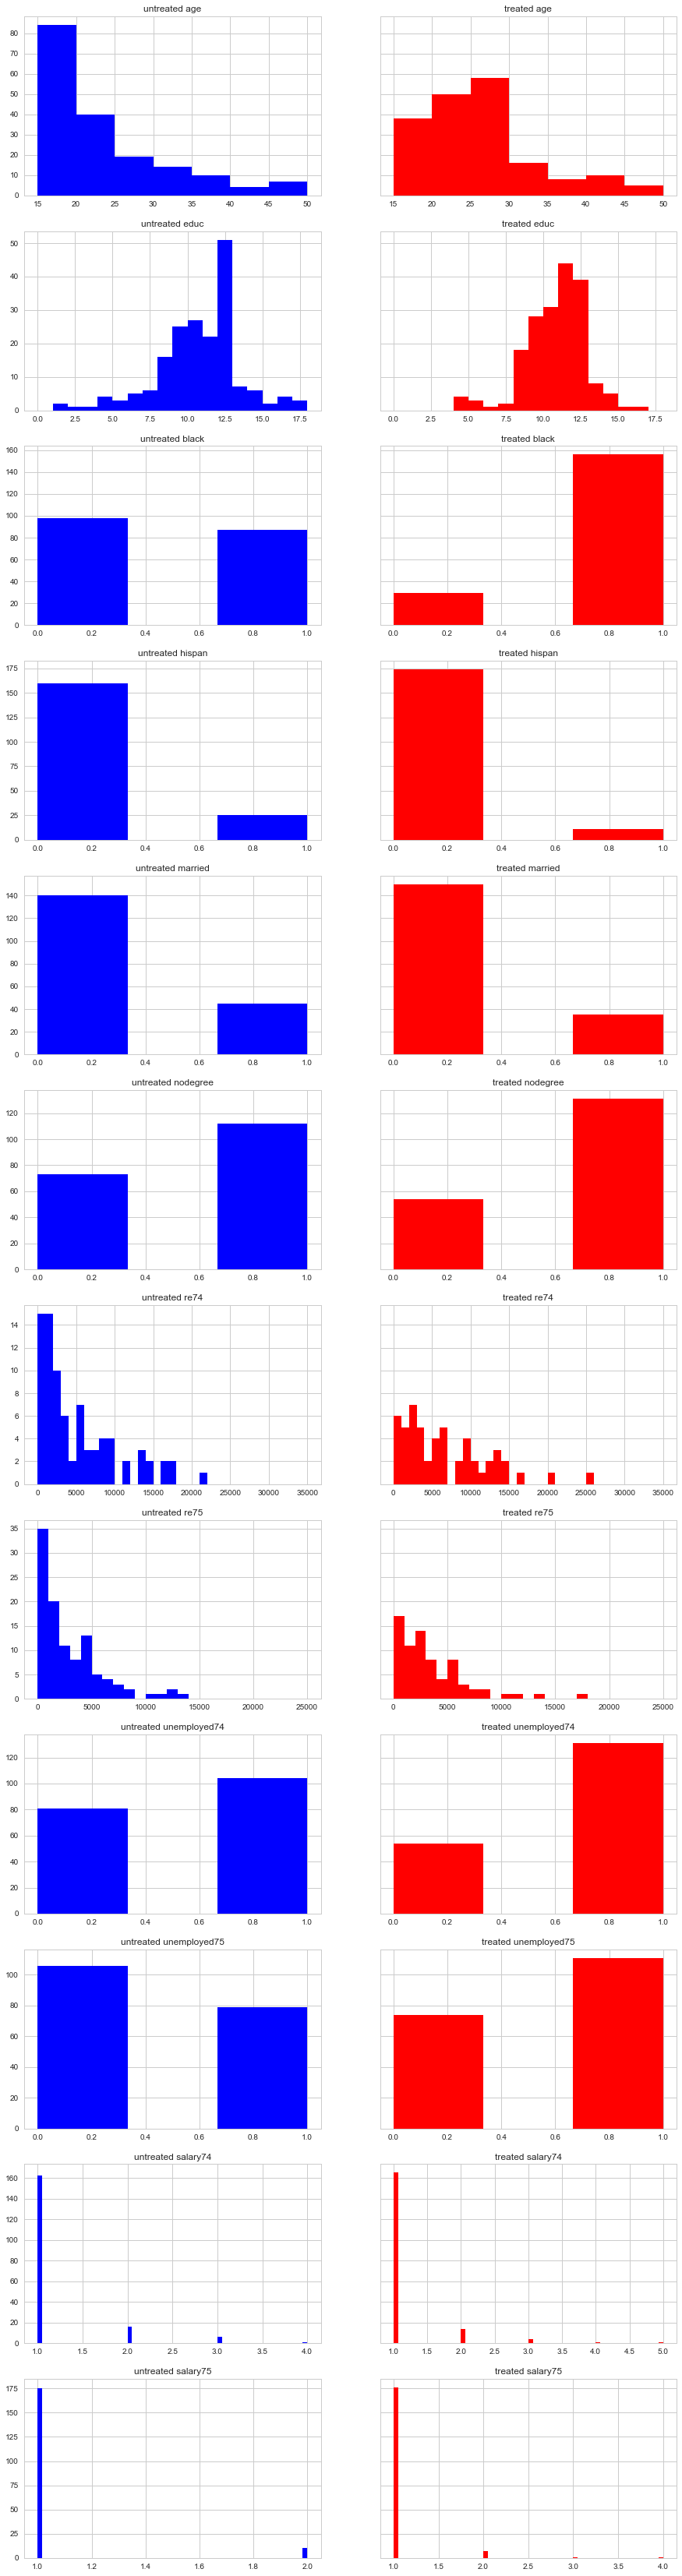

In [35]:
# we can use the same function created earlier this time with each features of the dataframe
values_list = []
title_list = []
bins_list = []
# we create different bins for the different data
bins_dic = {
    'age': range(15, 55, 5),
    'educ': range(0, 19, 1),
    'black': 3,
    'hispan': 3,
    'married': 3,
    'nodegree': 3,
    'unemployed74': 3,
    'unemployed75': 3,
    're74': range(0, 36000, 1000),
    're75': range(0, 26000, 1000)
}

for col in matched_untreated_df.drop(['treat', 're78', 'id', 'treat_0', 'treat_1'], axis=1).columns:
    # we remove the proheminent 0 value in revenue
    if col in ['re74', 're75']:
        values_list.append(matched_untreated_df[[col]].query("{} > 0".format(col)).values)
        values_list.append(treated_df[[col]].query("{} > 0".format(col)).values)
    else:
        values_list.append(matched_untreated_df[col].values)
        values_list.append(treated_df[col].values)
    title_list.append("{}".format(col))
    bins_list.append(bins_dic.get(col, 60)) # we set at 60 bins for each

plt_side_hist(values_list, title_list, bins_list, sharey='row') 

We confirm our result by looking at the different histogram distribution. Note that this time, we used share y as the number of sample is the same in the 2 groups.  We can see an overall similar distribution for most of the feature. However we can clearly point out the disparity on the etnic features such as black and hispanic. We observe that the black feature is probably the one that is maybe matching the less in term of distribution in the 2 groups.

Now we will observe what it's going to give us in terms of box plot.

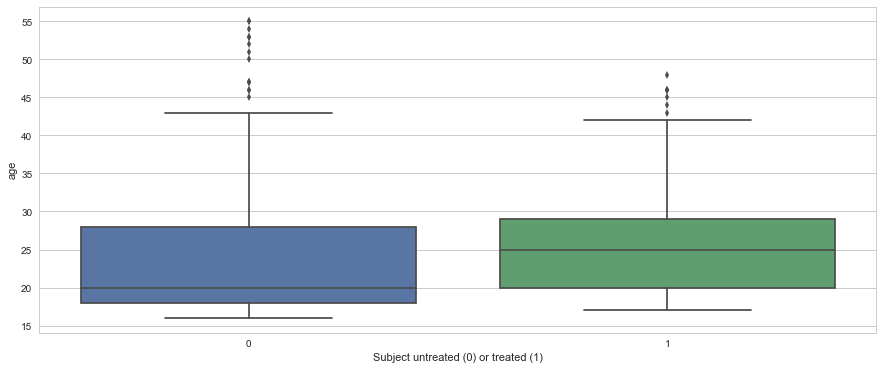

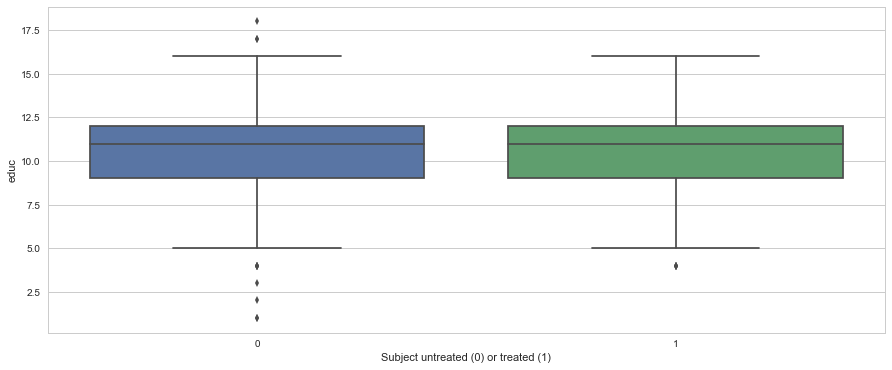

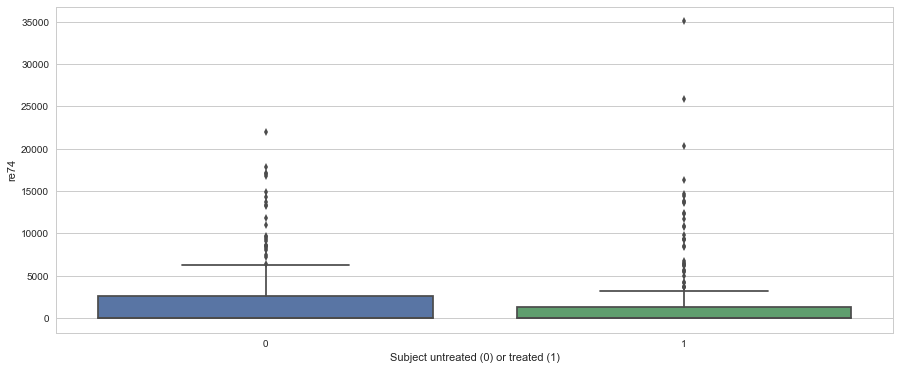

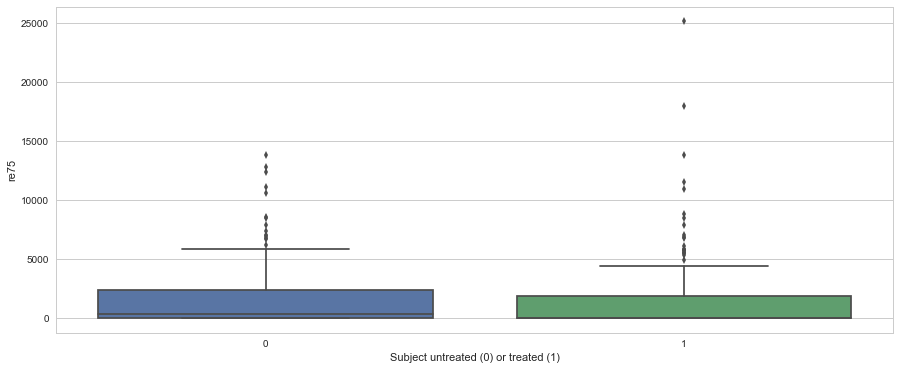

In [37]:
# plot the different boxplot side by side (with binary feature removed)
for col in matched_untreated_df.drop(
    ['id', 'treat_0', 'treat_1', 'treat','black', 'hispan', 'married', 'nodegree', 're78', 'salary74', 'salary75', 'unemployed74', 'unemployed75'], axis=1).columns:
    fig = plt.figure(figsize=[15,6])
    ax = sns.boxplot( data=[matched_untreated_df[col].values, treated_df[col].values])
    ax.set(xlabel='Subject untreated (0) or treated (1)', ylabel=col)

We see again some outliers on the revenue that influence the stats but overall we got similar median and reparittion over the different features which is good.

To conclude this question, our matching was good in the sense that we now have 2 groups of same size with closer features in almost every aspect except etnical aspects. The etnical aspect could be an important factor and influence the final revenue so let's correct this in the next question.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

As explained above and from the stats and graph analysis we can say that we are not fully satisfied of the matching particularly on the etnical aspect. Indeed black people are a lot more represented in the treated set compare to the matched untreated one. Further more hispanic people are a lot more present in the matched untreated set. This difference could definetly influence the final revenue they have years after the training hence making us unable to compare the 2 groups.

To improve our matching and take into account this result, we can modify our graph to have edges only between people of same etnical origin. That would force the matching algorithm to match only people of same etnical background together.

In [43]:
# let's do that
# create a bipartite graph from these dataframe.
# it's worth noting that since the index are from 0 to 184 for the treated subject and from 185 to to the end for
# the untreated one we can directly assume that the bipartite graph will use the correct indices.

G = nx.Graph()

# we now set the weight to be the absolute difference between propensity score for each edge
for treated_index in treated_propensity_score_df.index:
    for untreated_index in untreated_propensity_score_df.index:
        if data.reset_index().loc[treated_index, 'black'] == data.reset_index().loc[untreated_index, 'black']:
            # we add 1 - because the function is trying to maximise the weight and we want to minize
            w = 1 - abs(treated_propensity_score_df.loc[treated_index,'treat_1'] - untreated_propensity_score_df.loc[untreated_index,'treat_1'])
            G.add_edge(treated_index, untreated_index, weight=w)
        
# we can finally maximise our graph using the max_weight_matching function
matching = nx.max_weight_matching(G)

In [51]:
data.iloc[185:614].describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75,treat_0,treat_1
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742,0.261072,0.312354,1.522145,1.116550,0.809673,0.190327
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791,0.439732,0.463995,0.833077,0.349139,0.204011,0.204011
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.232013,0.015559
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300,0.000000,0.000000,1.000000,1.000000,0.757471,0.057264
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000,0.000000,0.000000,1.000000,1.000000,0.903663,0.096337
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000,1.000000,1.000000,2.000000,1.000000,0.942736,0.242529
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000,1.000000,1.000000,4.000000,3.000000,0.984441,0.767987


In [57]:
# we can again create a new dataframe from this new matching and see the result this time
# create a new dataFrame containing the score and the matched index to be able to concat later
new_matched_data = treated_df.reset_index()
new_matched_data['matched_idx'] = 0
new_matched_data['matched_score'] = 0

# iterate over the matching just realised and fill in the df
for key, value in matching.items():
    if key in treated_propensity_score_df.index:
        new_matched_data.loc[key, 'matched_idx'] = value
        new_matched_data.loc[key, 'matched_score'] = G.get_edge_data(key, value)['weight']

# as there is not enough black people the matching is wrong and we have to correct it by removing all the 0 matched_idx
new_matched_data = new_matched_data.query('matched_idx > 0')

# finally we can create a dataframe containing only the new matched subjects with the new matching
new_matched_untreated_df = data.reset_index().loc[new_matched_data['matched_idx'].tolist(), :]
new_treated_df = data.reset_index().loc[new_matched_data.index.tolist(), :]
print("Shape of the new dataframe {}".format(new_matched_untreated_df .shape))

Shape of the new dataframe (116, 17)


Now let's check our results stats result on the newly matched untreated dataFrame and compare it again with the treated one.

In [55]:
new_matched_untreated_df.drop(['treat_0','treat_1'], axis=1).describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75
count,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,0.0,25.137931,10.172414,0.750000,0.094828,0.258621,0.629310,2856.948829,1823.412620,5030.232183,0.482759,0.439655,1.241379,1.077586
std,0.0,10.355336,2.884067,0.434891,0.294248,0.439776,0.485085,4961.895386,3012.550719,6073.458098,0.501871,0.498498,0.584148,0.268680
min,0.0,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.0,18.000000,9.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.0,20.000000,10.500000,1.000000,0.000000,0.000000,1.000000,114.617085,308.830600,2256.488500,0.000000,0.000000,1.000000,1.000000
75%,0.0,29.000000,12.000000,1.000000,0.000000,1.000000,1.000000,2693.502250,2262.967500,7866.308250,1.000000,1.000000,1.000000,1.000000
max,0.0,55.000000,17.000000,1.000000,1.000000,1.000000,1.000000,21918.320000,13776.530000,20243.380000,1.000000,1.000000,4.000000,2.000000


In [59]:
new_treated_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,unemployed74,unemployed75,salary74,salary75,treat_0,treat_1
count,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,1.0,26.215517,10.362069,0.750000,0.094828,0.275862,0.715517,3214.327159,2177.839613,6369.295279,0.560345,0.465517,1.250000,1.103448,0.518158,0.481842
std,0.0,7.508611,1.838698,0.434891,0.294248,0.448887,0.453125,5839.044022,3796.656039,6697.118767,0.498498,0.500974,0.644374,0.403879,0.207164,0.207164
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.231512,0.036023
25%,1.0,20.000000,9.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,665.300000,0.000000,0.000000,1.000000,1.000000,0.324618,0.301724
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,334.049350,4895.704000,1.000000,0.000000,1.000000,1.000000,0.474083,0.525917
75%,1.0,30.000000,12.000000,1.000000,0.000000,1.000000,1.000000,3789.160500,2793.707250,9940.204750,1.000000,1.000000,1.000000,1.000000,0.698276,0.675382
max,1.0,46.000000,14.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,36646.950000,1.000000,1.000000,5.000000,4.000000,0.963977,0.768488


We also plot the histograms and boxplot to have visual support on the difference between the 2 groups.

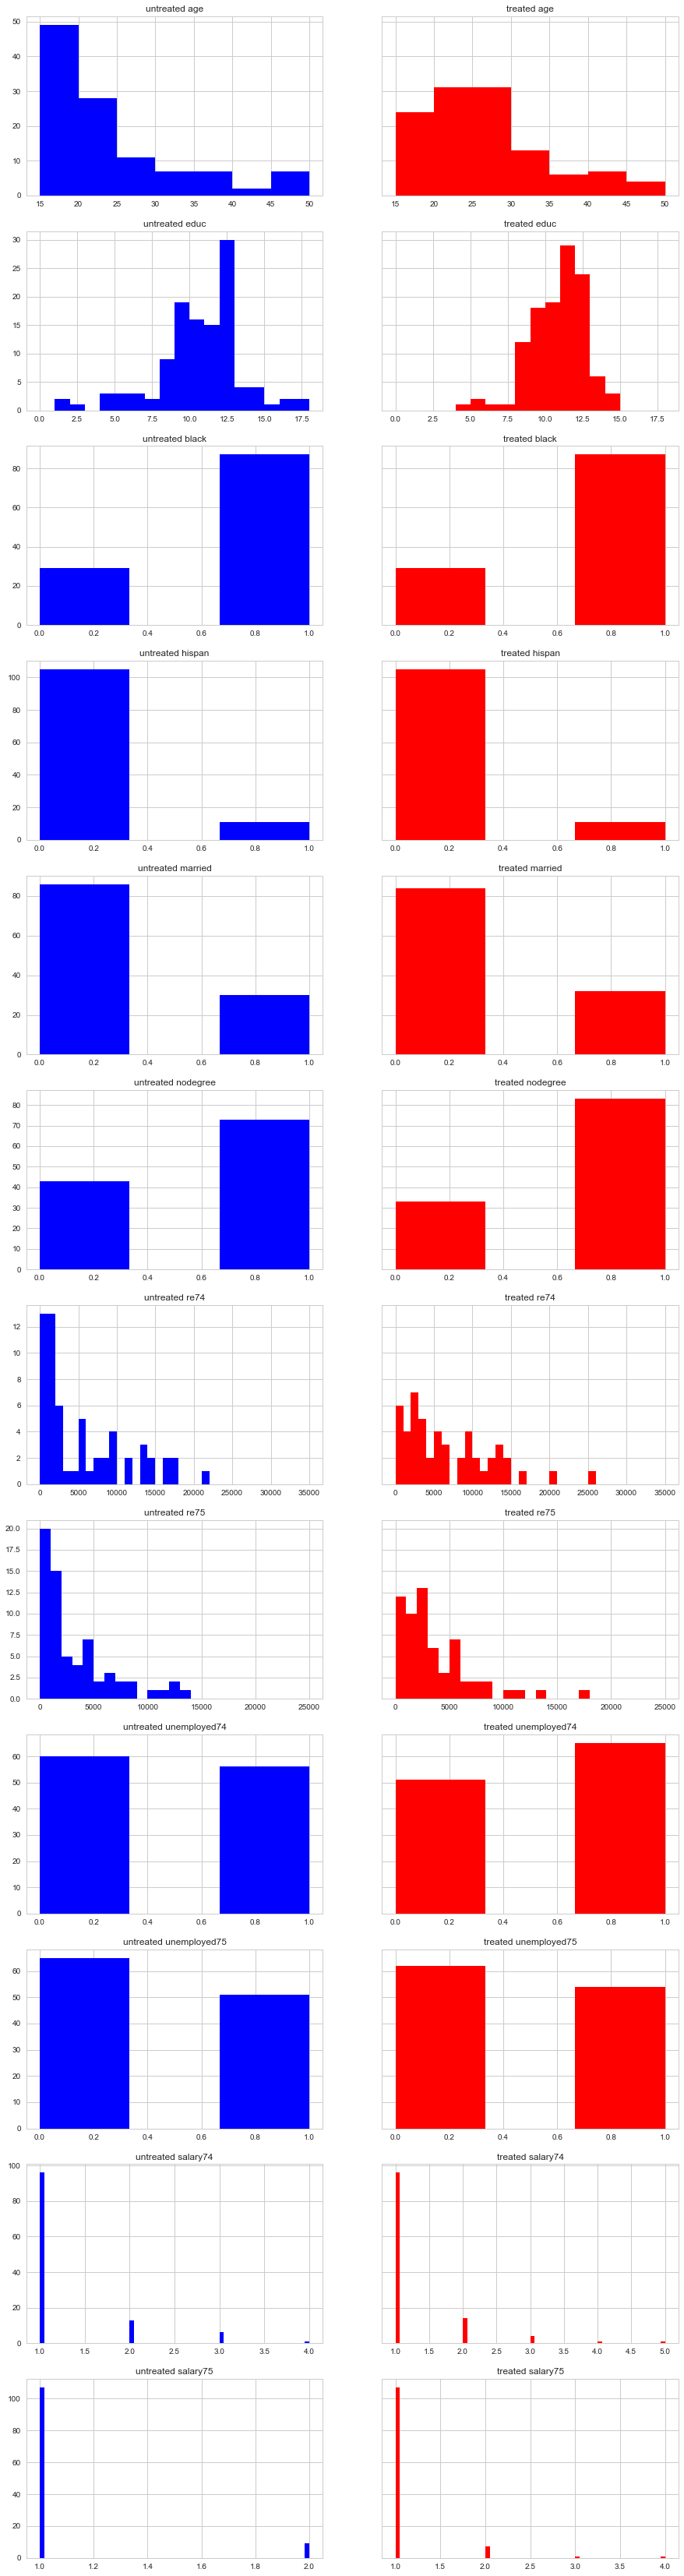

In [62]:
# we can use the same function created earlier this time with each features of the dataframe
values_list = []
title_list = []
bins_list = []
# we create different bins for the different data
bins_dic = {
    'age': range(15, 55, 5),
    'educ': range(0, 19, 1),
    'black': 3,
    'hispan': 3,
    'married': 3,
    'nodegree': 3,
    'unemployed74': 3,
    'unemployed75': 3,
    're74': range(0, 36000, 1000),
    're75': range(0, 26000, 1000)
}

for col in new_matched_untreated_df.drop(['treat', 're78', 'id', 'treat_0', 'treat_1'], axis=1).columns:
    # we remove the proheminent 0 value in revenue
    if col in ['re74', 're75']:
        values_list.append(new_matched_untreated_df[[col]].query("{} > 0".format(col)).values)
        values_list.append(new_treated_df[[col]].query("{} > 0".format(col)).values)
    else:
        values_list.append(new_matched_untreated_df[col].values)
        values_list.append(new_treated_df[col].values)
    title_list.append("{}".format(col))
    bins_list.append(bins_dic.get(col, 60)) # we set at 60 bins for each

plt_side_hist(values_list, title_list, bins_list, sharey='row') 

We can observe on almost every feature a very high similiraty in their distribution and of course an identical distribution on the black feature. The matching seems to be much better looking at both the stats and histogram distribution we can see that the value are matching a lot more than before.

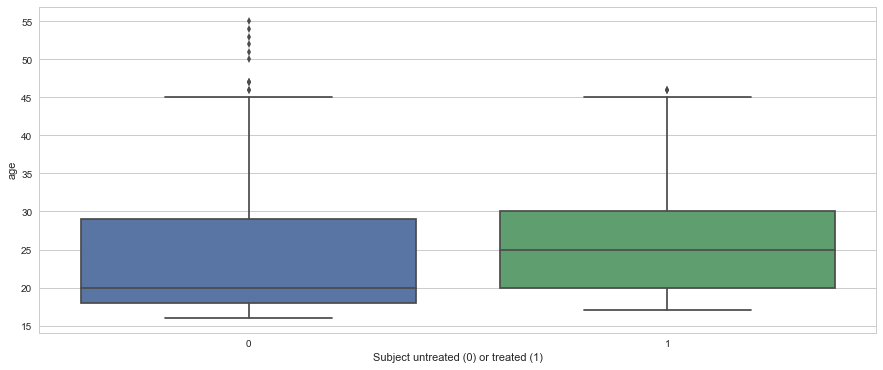

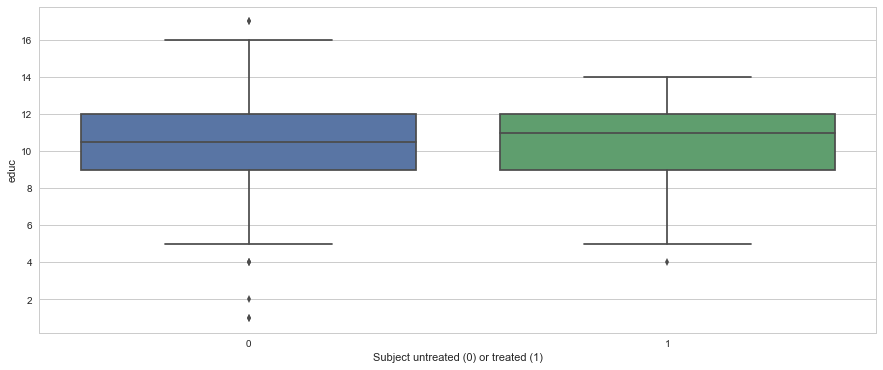

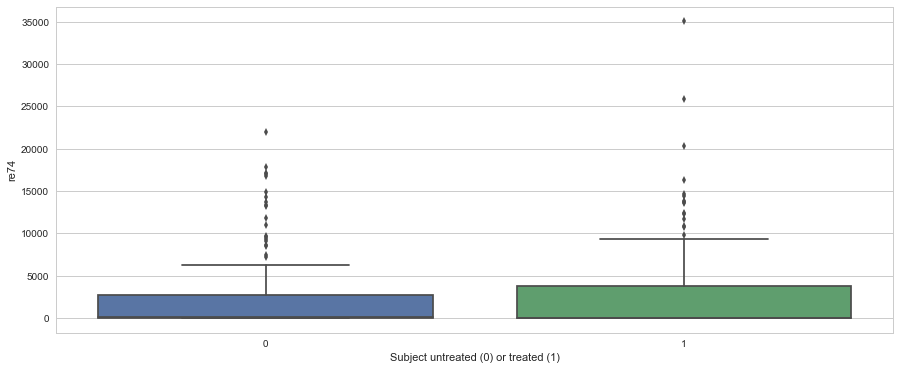

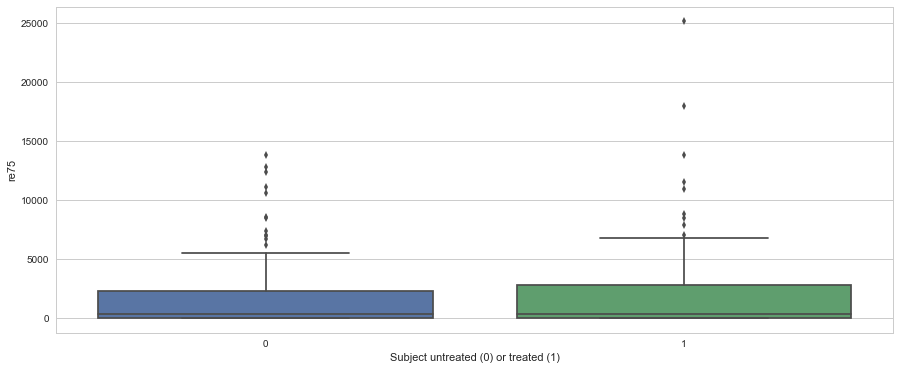

In [63]:
# plot the different boxplot side by side (with binary feature removed)
for col in new_matched_untreated_df.drop(
    ['id', 'treat_0', 'treat_1', 'treat','black', 'hispan', 'married', 'nodegree', 're78', 'unemployed74', 'unemployed75', 'salary74', 'salary75'], axis=1).columns:
    fig = plt.figure(figsize=[15,6])
    ax = sns.boxplot( data=[new_matched_untreated_df[col].values, new_treated_df[col].values])
    ax.set(xlabel='Subject untreated (0) or treated (1)', ylabel=col)

We now observe a completly identical distribution and value on the black feature which is obvious since we matched only black subject with other black subject. The other features seem to have remained not so impacted by the fact that we forced the etnicity in our matching.
However this forced matching cost us to lose an important amount of data which could impact our final refined analysis.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?



Using the new matched untreated group we can now repeat the analysis from part 1:

In [64]:
# use describe on the treated dataframe
new_treated_df[['re78']].describe()

,re78
count,116.000000
mean,6369.295279
std,6697.118767
min,0.000000
25%,665.300000
50%,4895.704000
75%,9940.204750
max,36646.950000


In [65]:
# use describe on the treated dataframe
new_matched_untreated_df[['re78']].describe()

,re78
count,116.000000
mean,5030.232183
std,6073.458098
min,0.000000
25%,0.000000
50%,2256.488500
75%,7866.308250
max,20243.380000


With our 2 matched dataset we now observe an improvement in the mean revenue after attending the training program. However we need to be careful are the mean is not robust and they might be some outliers influencing it. We also abserve that the first quartile is situated at 665 for the treated subject compare to 0 which could let us think that the unemployement rate is much lower after the training. We also observe a much higher median value on the treated subjects.

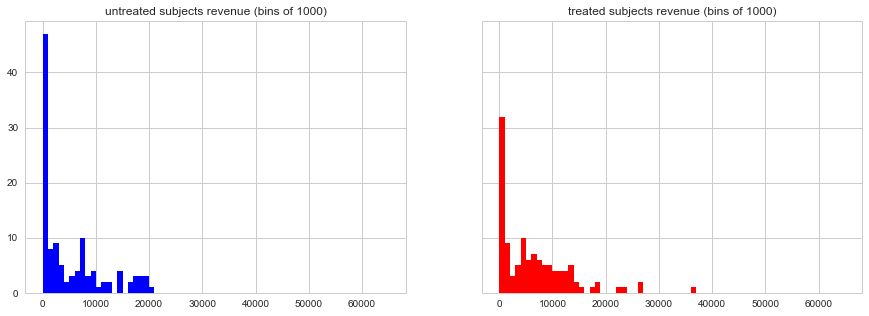

In [67]:
# histogram of the untreated and treated subjects
values_list = [new_matched_untreated_df['re78'].values, new_treated_df['re78'].values]
title_list = ["subjects revenue (bins of 1000)"]
bins_list = [range(0, 66000, 1000)]

plt_side_hist(values_list, title_list, bins_list, sharey=True)

On this histogram we observe that there is indeed a lot less subject unemployed after the training program.

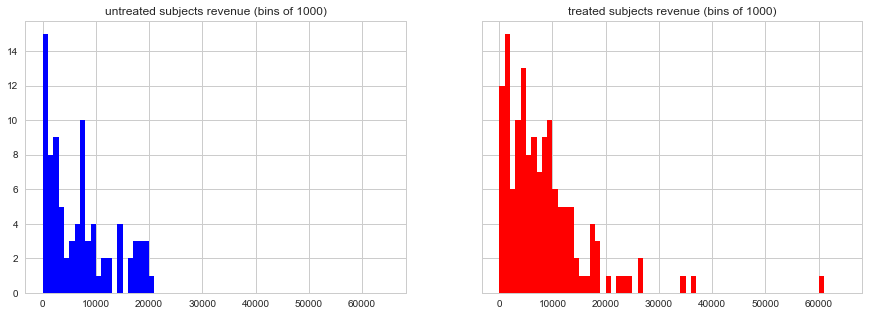

In [68]:
# same thing as above this time keeping only values above 0
values_list = [new_matched_untreated_df[['re78']].query('re78 > 0').values, 
               treated_df[['re78']].query('re78 > 0').values]
title_list = ["subjects revenue (bins of 1000)"]
bins_list = [range(0, 66000, 1000)]

plt_side_hist(values_list, title_list, bins_list, sharey=True)

The distribution without the unemployed subjects doesn't tell us much except that there is some outliers in the treated subjects so we should be carefull when using not robust data such as the mean (see above). Let's confirm our result with some boxplot.

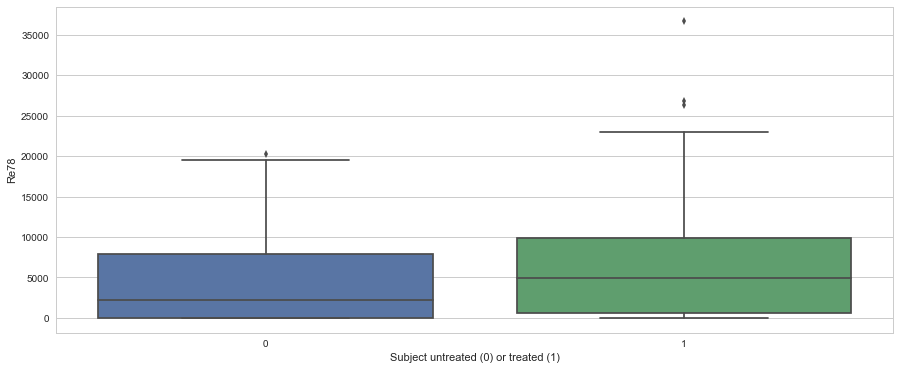

In [69]:
fig = plt.figure(figsize=[15,6])
ax = sns.boxplot( data=[new_matched_untreated_df['re78'].values, new_treated_df['re78'].values])
_ = ax.set(xlabel='Subject untreated (0) or treated (1)', ylabel='Re78')

And we can observe even better on these boxplots that the different quartile are higher for the revenue value after taking the training program. Note that we also observe here the outliers we previously saw on the histogram.

In [81]:
print("unemployed untreated before the program:", len(new_matched_untreated_df.query('unemployed75 == 1')))
print("unemployed untreated after the program:", len(new_matched_untreated_df.query('re78 == 0')))
print("unemployed treated before the program:", len(new_treated_df.query('unemployed75 == 1')))
print("unemployed treated after the program:", len(new_treated_df.query('re78 == 0')))

unemployed untreated before the program: 51
unemployed untreated after the program: 32
unemployed treated before the program: 54
unemployed treated after the program: 25


To conclude after matching our dataset using the propensity score we can now clearly state that the training program seemed to have proved useful on the population. We have a higher mean, median and every different quartile are higher. We can also assume that the training program helped reduce unemployement. Indeed on comparable population we observe a reduction of 25% unemployement rate reduction on the trained subject compared to only 16.5% reduction on the untrained subject.

___

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories.

#### 1. Configuration

We load the 20newsgroup dataset. It is a classic dataset that can directly be loaded using sklearn.  

In [1]:
# usual import section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
sns.set(context='notebook', style='whitegrid')

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn import metrics

import scipy # conda install scipy
import random
from scipy.sparse import vstack

import networkx as nx

%matplotlib inline

In [2]:
newsgroups = fetch_20newsgroups(subset='all', data_home="./")

The dataset id composed of different labels :

In [3]:
pprint(list(newsgroups.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [4]:
newsgroups.target.shape

(18846,)

The dataset is composed of 18846 items. Here is an example of one of them. 

In [5]:
print("\n".join(newsgroups.data[0].split("\n")))

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). We compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

We use stop_words="english" to clean words than don't give informations.

In [6]:
vectorizer = TfidfVectorizer(stop_words='english')
data_tfidf = vectorizer.fit_transform(newsgroups.data)
data_tfidf.shape

(18846, 173451)

For each item of the dataset (18846) we have 173451 columns that represent each word frequency. Here is an example of words represented on columns. 

In [7]:
vectorizer.get_feature_names()[-90450:-90440]

['hailwood',
 'haim',
 'haimes',
 'hain',
 'hainaut',
 'haines',
 'hair',
 'hairball',
 'haircut',
 'hairdresser']

Then, we split our dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

The dataset may be ordered in a particular order, we decide to split 3 groups randomly and ensure that they are on the same format.

In [8]:
subset_size = round(len(newsgroups.target) * 0.1)
news_validation = [0] * subset_size
tfidf_validation = []
news_train = [0] * subset_size
tfidf_train = []

i = 0
while i < subset_size:
    item_id = random.randint(1, len(newsgroups.target))
    # Store
    news_validation[i] = newsgroups.target[item_id]
    tfidf_validation = vstack((tfidf_validation, data_tfidf[item_id]))
    # Delete
    newsgroups.target = np.delete(newsgroups.target, item_id)
    data_tfidf = scipy.sparse.vstack([data_tfidf[:item_id-1, :], data_tfidf[item_id:, :]])

    item_id = random.randint(1, len(newsgroups.target))
    # Store
    news_train[i] = newsgroups.target[item_id]
    tfidf_train = vstack((tfidf_train, data_tfidf[item_id]))
    # Delete
    newsgroups.target = np.delete(newsgroups.target, item_id)
    data_tfidf = scipy.sparse.vstack([data_tfidf[:item_id-1, :], data_tfidf[item_id:, :]])

    i = i+1

news_test = newsgroups.target
tfidf_test = data_tfidf

news_validation = np.asarray(news_validation)
tfidf_validation = tfidf_validation.tocsr()[1:]

news_train = np.asarray(news_train)
tfidf_train = tfidf_train.tocsr()[1:]

#### 2. Applied ML

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

We take the validation and apply a grid search on the "max_depth" and "n_estimators" parameters to determine which values give the best results.

The processing time could be very long for this step. In order to decrease the process time, we choose to iterate with big steps. 

In [12]:
depths = range(1, 62, 5)
n_estimators= range(1, 1502, 100)
best_predi_score = 0
best_depth = -1
best_n_estimators = -1

for depth in depths:
    print('Depth: ', depth)
    
    for n_estimator in n_estimators:
        
        clf = RandomForestClassifier(max_depth= depth, n_estimators= n_estimator, random_state=1, n_jobs = -1)
        clf.fit(tfidf_train, news_train)
        
        predictions_validation = clf.predict(tfidf_validation)
        
        prediction_score = metrics.accuracy_score(news_validation, predictions_validation)
        
        if prediction_score > best_predi_score:
            best_predi_score = prediction_score
            best_depth = depth
            best_n_estimators = n_estimator
            
print(best_depth, best_n_estimators, best_predi_score)

Depth:  1
Depth:  6
Depth:  11
Depth:  16
Depth:  21
Depth:  26
Depth:  31
Depth:  36
Depth:  41
Depth:  46
Depth:  51
Depth:  56
Depth:  61
61 1301 0.670557029178


Now we set a random forest with the best parameters of the grid search.

We train and and finally test the random forest.

In [20]:
clf = RandomForestClassifier(max_depth= best_depth, n_estimators= best_n_estimators, random_state= 1, n_jobs = -1)
clf.fit(tfidf_train, news_train)
predictions = clf.predict(tfidf_test)
print(metrics.accuracy_score(news_test, predictions))

0.622512602812


We plot the confusion matrix for our predictions.

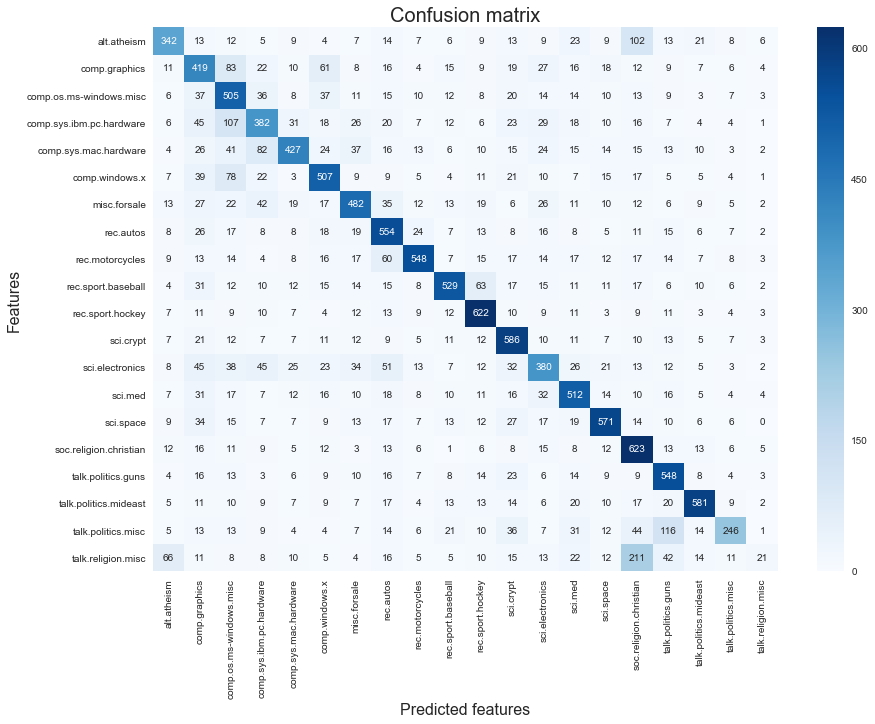

In [14]:
confusion_matrix = metrics.confusion_matrix(news_test, predictions)
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(confusion_matrix, xticklabels=newsgroups.target_names, yticklabels=newsgroups.target_names, ax=ax, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix")
ax.set_xlabel("Predicted features")
ax.set_ylabel("Features")

We see with the confusion matrix that there is very high values on the diagonal in comparison to the other square so we can conclude that our model perform good predictions. 

We see some confusion especially on the items where they share the same group. For example "talk.religion.misc" and "soc.religion.christian".

___
Now, we inspect the feature importances attribute of your random forest. In our case, the features are words. First, we need to filter the features that are non zeros. When it's zero, the feature has no importance for the prediction. A word who is in every post or a word that is only in one post will have a zero because it is not helping the selection.   

In [15]:
features = len(clf.feature_importances_)
non_zero =  clf.feature_importances_[clf.feature_importances_ != 0]
print(len(non_zero)/features*100)

19.520786850464972


There is 19.5% of features that are non zeros. We plot the different features.

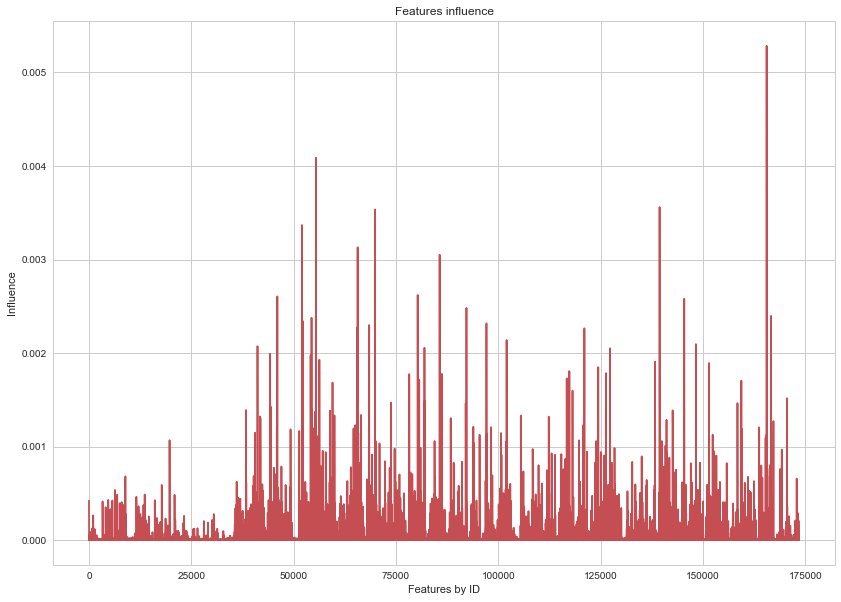

In [21]:
fig, ax = plt.subplots(figsize=(14,10))
plt.plot(clf.feature_importances_, color='C2')
plt.title("Features influence")
ax.set_xlabel("Features by ID")
ax.set_ylabel("Influence")

We can see with this graph that the importance between word is totally different. 

Here are the most important features. They help the most to predict the category for the article. 

In [22]:
important_words = clf.feature_importances_.argsort()[-30:][::-1]
print(("\n".join(np.array(vectorizer.get_feature_names())[important_words])))

windows
clipper
sale
encryption
car
dod
hockey
god
bike
space
israel
writes
christian
cars
key
edu
doctor
organization
lines
subject
article
gun
posting
baseball
chip
com
rutgers
team
people
nntp


Windows come first, it mean that this word help a lot to choose the category. We guess one of the categories who have "windows" in its name.